In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

con = cx_Oracle.connect("windquery", "wind2010query", "10.2.89.132:1521/winddb")

## 查询中信一级行业代码及成分股

In [2]:
## cics_level1 = [
##    "CI005001.WI","CI005002.WI","CI005003.WI","CI005004.WI","CI005005.WI",
##    "CI005006.WI","CI005007.WI","CI005008.WI","CI005009.WI","CI005010.WI",
##    "CI005011.WI","CI005012.WI","CI005013.WI","CI005014.WI","CI005015.WI",
##    "CI005016.WI","CI005017.WI","CI005018.WI","CI005019.WI","CI005020.WI",
##    "CI005021.WI","CI005022.WI","CI005023.WI","CI005024.WI","CI005025.WI",
##    "CI005026.WI","CI005027.WI","CI005028.WI"
## ]

In [3]:
# 中信一级行业代码
cics_level1 = ["CI005001.WI","CI005002.WI","CI005003.WI"] # 先拿三个方便计算

code_tuple_str = "(" + ",".join([f"'{x}'" for x in cics_level1]) + ")"

# 中信一级行业指数和成分股映射关系
sql = f"""
SELECT
    S_INFO_WINDCODE   AS INDEX_CODE,
    S_CON_WINDCODE    AS STOCK_CODE,
    S_CON_INDATE      AS ENTRY_DT,
    S_CON_OUTDATE     AS REMOVE_DT
FROM WIND.AINDEXMEMBERSCITICS
WHERE S_INFO_WINDCODE IN {code_tuple_str}
"""

industry_stock_pool = pd.read_sql(sql, con)
industry_stock_pool.head()

,INDEX_CODE,STOCK_CODE,ENTRY_DT,REMOVE_DT
0,CI005001.WI,600938.SH,20220415,None
1,CI005001.WI,001316.SZ,20220601,None
2,CI005001.WI,603223.SH,20221213,None
3,CI005001.WI,603318.SH,20221213,None
4,CI005001.WI,600800.SH,20210401,None


## 计算CANSLIM：Crowd

In [4]:
lookback_highlow = 250   # 新高新低窗口
active_win = 20          # 活跃成交额窗口
top_pct = 0.30           # 行业内成交额Top比例
start_dt = 20111201

In [ ]:
# 计算Crowd函数
def compute_crowd_for_one_index_fix(con, index_code: str,
                                   start_dt: int = 20130101,
                                   lookback_highlow: int = 250,
                                   active_win: int = 20,
                                   top_pct: float = 0.30) -> pd.DataFrame:

    sql = f"""
    SELECT
        p.TRADE_DT,
        p.S_INFO_WINDCODE AS STOCK_CODE,
        '{index_code}' AS INDEX_CODE,
        p.S_DQ_CLOSE,
        p.S_DQ_AMOUNT,
        m.S_CON_INDATE AS ENTRY_DT,
        NVL(m.S_CON_OUTDATE, 99991231) AS REMOVE_DT
    FROM WIND.ASHAREEODPRICES p
    JOIN WIND.AINDEXMEMBERSCITICS m
      ON p.S_INFO_WINDCODE = m.S_CON_WINDCODE
    WHERE m.S_INFO_WINDCODE = '{index_code}'
      AND p.TRADE_DT >= '{start_dt}'
    ORDER BY p.TRADE_DT, p.S_INFO_WINDCODE
    """

    df = pd.read_sql(sql, con).dropna(subset=["S_DQ_CLOSE","S_DQ_AMOUNT"])

    # 在全历史上算 rolling
    df = df.sort_values(["STOCK_CODE","TRADE_DT"])
    g = df.groupby("STOCK_CODE", group_keys=False)

    df["roll_max"] = g["S_DQ_CLOSE"].transform(lambda s: s.shift(1).rolling(lookback_highlow, min_periods=lookback_highlow).max())
    df["roll_min"] = g["S_DQ_CLOSE"].transform(lambda s: s.shift(1).rolling(lookback_highlow, min_periods=lookback_highlow).min())
    df["amt_ma"]   = g["S_DQ_AMOUNT"].transform(lambda s: s.rolling(active_win, min_periods=active_win).mean())
    
    df["is_new_high"] = (df["S_DQ_CLOSE"] >= df["roll_max"]).astype(int)
    df["is_new_low"]  = (df["S_DQ_CLOSE"] <= df["roll_min"]).astype(int)

    # rolling 不足的行去掉，否则后面排名会乱
    df = df.dropna(subset=["amt_ma"])

    # 现在再套成分股生效期：只在“统计口径”里算
    df = df[(df["TRADE_DT"] >= df["ENTRY_DT"]) & (df["TRADE_DT"] <= df["REMOVE_DT"])].copy()
    if df.empty:
        return pd.DataFrame(columns=["INDEX_CODE","TRADE_DT","CROWD","n_high","n_low","n_active"])

    # 行业内每日日成交额排名百分位
    df["amt_rank_pct"] = df.groupby(["INDEX_CODE","TRADE_DT"])["amt_ma"].rank(pct=True, ascending=False)
    df["is_active"] = (df["amt_rank_pct"] <= top_pct).astype(int)

    agg = df.groupby(["INDEX_CODE","TRADE_DT"]).agg(
        n_high=("is_new_high","sum"),
        n_low=("is_new_low","sum"),
        n_active=("is_active","sum"),
    ).reset_index()

    min_active = 10 # 最小活跃股数

    agg["CROWD"] = (agg["n_high"] - agg["n_low"]) / agg["n_active"].replace(0, np.nan)
    agg.loc[agg["n_active"] < min_active, "CROWD"] = np.nan

    return agg[["INDEX_CODE","TRADE_DT","CROWD","n_high","n_low","n_active"]].sort_values(["TRADE_DT"])

In [5]:
# 按行业逐个计算Crowd
all_results = []
for idx in cics_level1:
    print(f"==> computing {idx} ...")
    one = compute_crowd_for_one_index_fix(con, idx, start_dt, lookback_highlow, active_win, top_pct)
    print("rows=", len(one),
          "crowd_nan_ratio=", one["CROWD"].isna().mean() if len(one)>0 else np.nan,
          "high_sum=", one["n_high"].sum() if len(one)>0 else 0,
          "low_sum=", one["n_low"].sum() if len(one)>0 else 0)
    all_results.append(one)

crowd_df = pd.concat(all_results, ignore_index=True)

tmp = crowd_df.sort_values(["INDEX_CODE", "TRADE_DT"]).copy()

crowd_df_use = (
    tmp.groupby("INDEX_CODE", group_keys=False)
       .apply(lambda x: x.iloc[lookback_highlow:])   # 250天后再用
       .dropna(subset=["CROWD"])
       .reset_index(drop=True)
)

print("原始行数:", len(crowd_df), "可用行数:", len(crowd_df_use))
crowd_df_use.head()

==> computing CI005001.WI ...
rows= 3412 crowd_nan_ratio= 0.03341148886283705 high_sum= 4262 low_sum= 4311
==> computing CI005002.WI ...
rows= 3413 crowd_nan_ratio= 0.003808965719308526 high_sum= 2840 low_sum= 4378
==> computing CI005003.WI ...
rows= 3410 crowd_nan_ratio= 0.002932551319648094 high_sum= 11166 low_sum= 12093
原始行数: 10235 可用行数: 9485


,INDEX_CODE,TRADE_DT,CROWD,n_high,n_low,n_active
0,CI005001.WI,20121220,0.000000,0,0,12
1,CI005001.WI,20121221,0.000000,0,0,12
2,CI005001.WI,20121224,0.083333,1,0,12
3,CI005001.WI,20121225,0.083333,1,0,12
4,CI005001.WI,20121226,0.083333,1,0,12


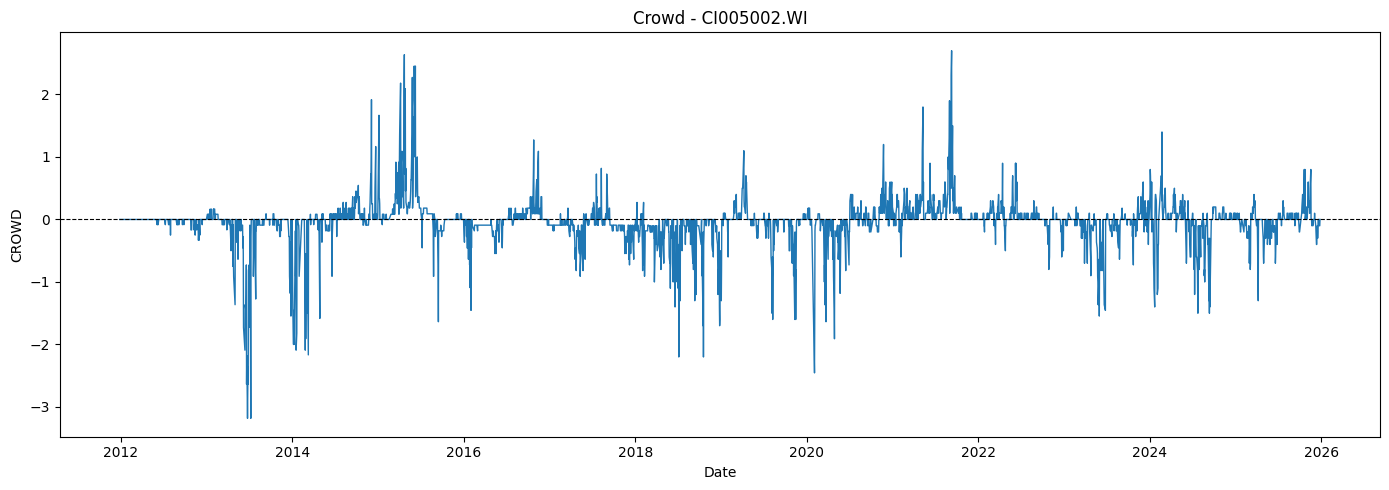

In [6]:
# 绘制Crowd例图
ind_code = "CI005002.WI"

one_ind = (
    crowd_df[crowd_df["INDEX_CODE"] == ind_code]
    .sort_values("TRADE_DT")
    .copy()
)

one_ind["TRADE_DT"] = pd.to_datetime(one_ind["TRADE_DT"].astype(str))

plt.figure(figsize=(14, 5))
plt.plot(one_ind["TRADE_DT"], one_ind["CROWD"], linewidth=1)

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)

plt.title(f"Crowd - {ind_code}")
plt.xlabel("Date")
plt.ylabel("CROWD")

plt.tight_layout()
plt.show()

## 计算CANSLIM：Analyst

In [7]:
def calc_analyst_two_metrics(con, index_code, start_dt):
    start_dt = int(start_dt)

    sql = f"""
    WITH mem AS (
        SELECT
            S_INFO_WINDCODE AS INDEX_CODE,
            S_CON_WINDCODE  AS STOCK_CODE,
            TO_NUMBER(S_CON_INDATE) AS ENTRY_DT,
            NVL(TO_NUMBER(S_CON_OUTDATE), 99991231) AS REMOVE_DT
        FROM WIND.AINDEXMEMBERSCITICS
        WHERE S_INFO_WINDCODE = '{index_code}'
    ),
    cons AS (
        SELECT
            S_INFO_WINDCODE AS STOCK_CODE,
            TO_NUMBER(EST_DT) AS TRADE_DT,
            SUM(NVL(NET_PROFIT_UPGRADE, 0))   AS UP_SUM,
            SUM(NVL(NET_PROFIT_DOWNGRADE, 0)) AS DOWN_SUM
        FROM WIND.ASHARECONSENSUSDATA
        WHERE TO_NUMBER(EST_DT) >= {start_dt}
        GROUP BY S_INFO_WINDCODE, TO_NUMBER(EST_DT)
    ),
    daily AS (
        SELECT
            m.INDEX_CODE,
            c.TRADE_DT,
            SUM(CASE WHEN c.UP_SUM   > c.DOWN_SUM THEN 1 ELSE 0 END) AS N_REC_STOCK,
            SUM(CASE WHEN c.DOWN_SUM > c.UP_SUM   THEN 1 ELSE 0 END) AS N_UNREC_STOCK,
            SUM(c.UP_SUM)   AS UP_SUM,
            SUM(c.DOWN_SUM) AS DOWN_SUM
        FROM mem m
        JOIN cons c
          ON c.STOCK_CODE = m.STOCK_CODE
         AND c.TRADE_DT  >= m.ENTRY_DT
         AND c.TRADE_DT  <= m.REMOVE_DT
        GROUP BY m.INDEX_CODE, c.TRADE_DT
    ),
    member_cnt AS (
        SELECT
            m.INDEX_CODE,
            d.TRADE_DT,
            COUNT(*) AS N_MEMBER
        FROM mem m
        JOIN (SELECT DISTINCT TRADE_DT FROM daily) d
          ON d.TRADE_DT >= m.ENTRY_DT AND d.TRADE_DT <= m.REMOVE_DT
        GROUP BY m.INDEX_CODE, d.TRADE_DT
    )
    SELECT
        d.INDEX_CODE,
        d.TRADE_DT,
        d.N_REC_STOCK,
        d.N_UNREC_STOCK,
        mc.N_MEMBER,
        d.UP_SUM,
        d.DOWN_SUM
    FROM daily d
    JOIN member_cnt mc
      ON d.INDEX_CODE = mc.INDEX_CODE
     AND d.TRADE_DT   = mc.TRADE_DT
    ORDER BY d.TRADE_DT
    """

    out = pd.read_sql(sql, con)
    for c in ["TRADE_DT","N_REC_STOCK","N_UNREC_STOCK","N_MEMBER","UP_SUM","DOWN_SUM"]:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out["ANALYST_REC"] = (out["N_REC_STOCK"] - out["N_UNREC_STOCK"]) / out["N_MEMBER"].replace(0, np.nan)

    out["dt"] = pd.to_datetime(out["TRADE_DT"].astype(int).astype(str))
    out = out.sort_values("dt")
    up_3m = out.set_index("dt")["UP_SUM"].rolling("90D").sum().values
    down_3m = out.set_index("dt")["DOWN_SUM"].rolling("90D").sum().values
    out["ANALYST_UP3M"] = (up_3m - down_3m) / (up_3m + down_3m + 1e-12)

    return out[["INDEX_CODE","TRADE_DT","ANALYST_REC","ANALYST_UP3M",
                "N_REC_STOCK","N_UNREC_STOCK","N_MEMBER","UP_SUM","DOWN_SUM"]]

In [8]:
all_results = []
for idx in cics_level1:
    print("==>", idx)
    all_results.append(calc_analyst_two_metrics(con, idx, start_dt))

analyst_df = pd.concat(all_results, ignore_index=True)

==> CI005001.WI
==> CI005002.WI
==> CI005003.WI


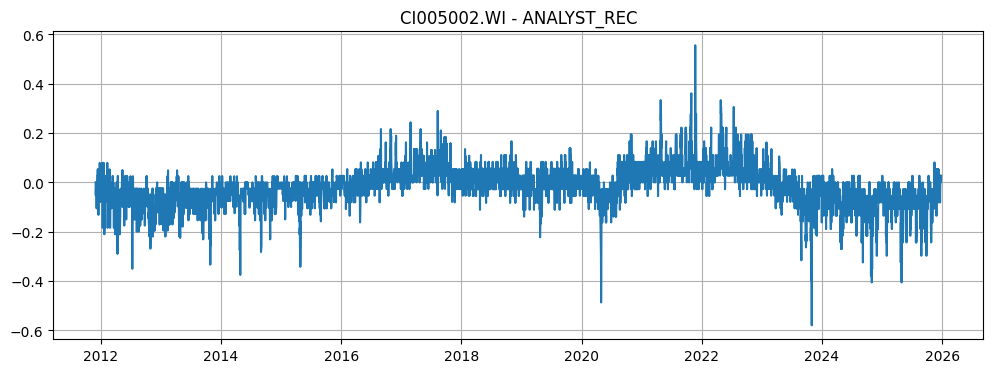

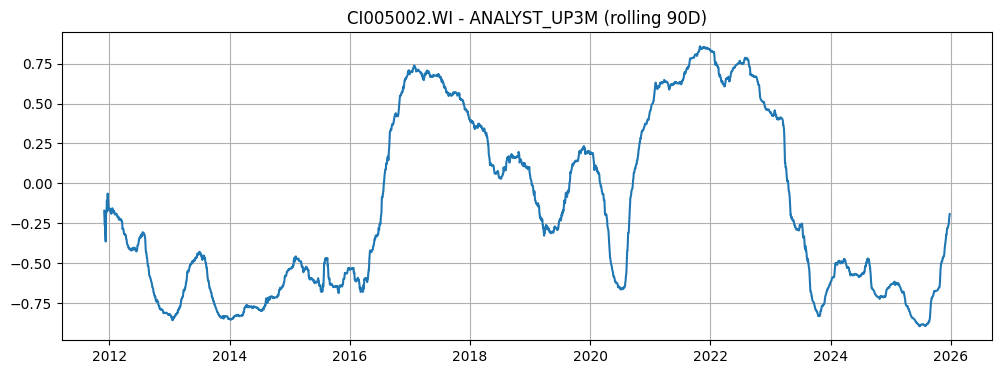

In [10]:
ind_code = "CI005002.WI" 
one = analyst_df[analyst_df["INDEX_CODE"] == ind_code].copy()
one["dt"] = pd.to_datetime(one["TRADE_DT"].astype(str))

plt.figure(figsize=(12,4))
plt.plot(one["dt"], one["ANALYST_REC"])
plt.title(f"{ind_code} - ANALYST_REC")
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(one["dt"], one["ANALYST_UP3M"])
plt.title(f"{ind_code} - ANALYST_UP3M (rolling 90D)")
plt.grid(True)
plt.show()

## 计算CANSLIM：Notable Profit

In [11]:
start_dt = 20120101

# 转换日期格式
def to_dt(x: pd.Series) -> pd.Series:
    return pd.to_datetime(x.astype(str), format="%Y%m%d", errors="coerce")

# z-score标准化
def zscore_rolling(s: pd.Series, win: int, minp: int) -> pd.Series:
    m = s.rolling(win, min_periods=minp).mean()
    sd = s.rolling(win, min_periods=minp).std(ddof=0)
    return (s - m) / sd.replace(0, np.nan)

# 生成日期并集，防止生成假日期
def build_trade_calendar(*dfs, date_col="TRADE_DT") -> pd.DataFrame:
    cal = pd.concat([df[[date_col]] for df in dfs if df is not None and len(df)], ignore_index=True)
    cal = cal.dropna().drop_duplicates().sort_values(date_col).reset_index(drop=True)
    return cal

# 取指数成分股及其纳入/剔除区间
def load_index_members(con, index_code: str) -> pd.DataFrame:
    sql = f"""
    SELECT
        S_CON_WINDCODE AS STOCK_CODE,
        TO_NUMBER(S_CON_INDATE) AS ENTRY_DT,
        NVL(TO_NUMBER(S_CON_OUTDATE), 99991231) AS REMOVE_DT
    FROM WIND.AINDEXMEMBERSCITICS
    WHERE S_INFO_WINDCODE = '{index_code}'
    """
    mem = pd.read_sql(sql, con)
    mem["ENTRY_DT"] = mem["ENTRY_DT"].astype(int)
    mem["REMOVE_DT"] = mem["REMOVE_DT"].astype(int)
    return mem

In [12]:
# 标准化预期外盈利
def calc_np_sue(con, mem: pd.DataFrame, start_dt: int, win: int = 252, minp: int = 60) -> pd.DataFrame:
    sql = f"""
    SELECT
        S_INFO_WINDCODE AS STOCK_CODE,
        TO_NUMBER(TRADE_DT) AS TRADE_DT,
        S_WEST_STDNETPROFIT_FY1,
        S_WEST_STDEPS_FY1
    FROM WIND.CONSENSUSEXPECTATIONFACTOR
    WHERE TO_NUMBER(TRADE_DT) >= {start_dt}
      AND (S_WEST_STDNETPROFIT_FY1 IS NOT NULL OR S_WEST_STDEPS_FY1 IS NOT NULL)
    """
    sue_raw = pd.read_sql(sql, con)

    # 只保留“在该日属于指数成分”的股票
    sue_raw = sue_raw.merge(mem, on="STOCK_CODE", how="inner")
    sue_raw = sue_raw.query("ENTRY_DT <= TRADE_DT <= REMOVE_DT").copy()

    sue_raw = sue_raw.sort_values(["STOCK_CODE", "TRADE_DT"])
    sue_raw["SUE_RAW"] = sue_raw.groupby("STOCK_CODE")["S_WEST_STDNETPROFIT_FY1"].pct_change()

    # 标准化 SUE
    sue_raw["SUE_Z"] = sue_raw.groupby("STOCK_CODE")["SUE_RAW"].transform(lambda s: zscore_rolling(s, win, minp))

    # 聚合到行业层面：当日成分股平均
    sue_daily = (
        sue_raw.groupby("TRADE_DT")
        .agg(
            NP_SUE_RAW=("SUE_Z", "mean"),
            N_STOCK=("STOCK_CODE", "nunique")
        )
        .reset_index()
    )

    # 再做一次行业层面的滚动标准化
    sue_daily = sue_daily.sort_values("TRADE_DT")
    sue_daily["NP_SUE"] = zscore_rolling(sue_daily["NP_SUE_RAW"], win, minp)

    return sue_daily

In [13]:
# 单季度ROE同比变化
def calc_np_delta_roeq(con, mem: pd.DataFrame, start_dt: int, win: int = 252, minp: int = 60) -> pd.DataFrame:
    sql = f"""
    SELECT
        S_INFO_WINDCODE AS STOCK_CODE,
        TO_NUMBER(ANN_DT) AS ANN_DT,
        TO_NUMBER(REPORT_PERIOD) AS REPORT_PERIOD,
        S_QFA_ROE
    FROM WIND.ASHAREFINANCIALINDICATOR
    WHERE TO_NUMBER(ANN_DT) >= {start_dt - 80000}
      AND S_QFA_ROE IS NOT NULL
    """
    fin = pd.read_sql(sql, con)

    # 成分过滤
    fin = fin.merge(mem, on="STOCK_CODE", how="inner")
    fin = fin.query("ENTRY_DT <= ANN_DT <= REMOVE_DT").copy()
    fin = fin.sort_values(["STOCK_CODE", "REPORT_PERIOD", "ANN_DT"])

    # 取“每个股票-每个报告期”最新一次披露
    fin = fin.drop_duplicates(["STOCK_CODE", "REPORT_PERIOD"], keep="last")

    # 同季度同比：ROE(t) - ROE(t-4)
    fin["ROE"] = fin["S_QFA_ROE"].astype(float)
    fin["ROE_LAG4"] = fin.groupby("STOCK_CODE")["ROE"].shift(4)
    fin["DELTA_ROEQ_RAW"] = fin["ROE"] - fin["ROE_LAG4"]

    # 股票内标准化
    fin["DELTA_ROEQ_Z"] = fin.groupby("STOCK_CODE")["DELTA_ROEQ_RAW"].transform(lambda s: zscore_rolling(s, win, minp))

    # 聚合到行业层面：以 ANN_DT 作为“可用日期”
    roe_daily = (
        fin.groupby("ANN_DT")
        .agg(
            NP_DELTA_ROEQ_RAW=("DELTA_ROEQ_Z", "mean"),
            N_STOCK=("STOCK_CODE", "nunique")
        )
        .reset_index()
        .sort_values("ANN_DT")
    )

    # 行业层面再标准化
    roe_daily["NP_DELTA_ROEQ"] = zscore_rolling(roe_daily["NP_DELTA_ROEQ_RAW"], win, minp)

    return roe_daily

In [14]:
# 工业企业利润同比
def calc_np_profit_yoy_proxy(con, index_code: str) -> pd.DataFrame:
    sql = f"""
    SELECT
        TO_NUMBER(TO_CHAR(OPDATE, 'YYYYMMDD')) AS TRADE_DT,
        NET_PROFIT_GROWTH_RATE AS IND_PROFIT_YOY
    FROM WIND.AINDEXFINANCIALDERIVATIVE
    WHERE S_INFO_WINDCODE = '{index_code}'
      AND OPDATE IS NOT NULL
      AND NET_PROFIT_GROWTH_RATE IS NOT NULL
    """
    ip = pd.read_sql(sql, con).dropna(subset=["TRADE_DT"]).copy()
    ip["TRADE_DT"] = ip["TRADE_DT"].astype(int)
    ip["IND_PROFIT_YOY"] = ip["IND_PROFIT_YOY"].astype(float)

    ip = ip.sort_values("TRADE_DT").drop_duplicates("TRADE_DT", keep="last").reset_index(drop=True)
    return ip

In [15]:
# 构建按交易日的 NotableProfit 三个序列
def build_notableprofit(con, index_code: str, start_dt: int,
                        win: int = 252, minp: int = 60,
                        debug: bool = False):

    mem = load_index_members(con, index_code)

    sue_daily = calc_np_sue(con, mem, start_dt=start_dt, win=win, minp=minp)
    roe_daily = calc_np_delta_roeq(con, mem, start_dt=start_dt, win=win, minp=minp)
    ip = calc_np_profit_yoy_proxy(con, index_code)

    # 用真实日期并集做“交易日历”
    cal = build_trade_calendar(
        sue_daily.rename(columns={"TRADE_DT": "TRADE_DT"}),
        ip,
        date_col="TRADE_DT"
    )

    out = cal.copy()

    # 1) SUE：直接按 TRADE_DT merge
    out = out.merge(sue_daily[["TRADE_DT", "NP_SUE"]], on="TRADE_DT", how="left")

    # 2) DeltaROEQ：财报/公告日 ANN_DT 映射到“之后最近交易日”
    roe_daily2 = roe_daily.rename(columns={"ANN_DT": "ANN_DT"}).sort_values("ANN_DT")
    out = out.sort_values("TRADE_DT")
    out = pd.merge_asof(
        out,
        roe_daily2[["ANN_DT", "NP_DELTA_ROEQ"]].sort_values("ANN_DT"),
        left_on="TRADE_DT",
        right_on="ANN_DT",
        direction="backward"  # 当日用最近一次已披露的数据
    ).drop(columns=["ANN_DT"])

    # 3) 工业企业利润同比：对齐交易日后 ffill，直接作为 level 使用
    out = out.merge(ip[["TRADE_DT", "IND_PROFIT_YOY"]], on="TRADE_DT", how="left")
    out["IND_PROFIT_YOY"] = (
        out["IND_PROFIT_YOY"]
        .ffill()
        .bfill()   # 用第一条可得值填充最早期
    )

    out["NP_PROFIT_YOY"] = out["IND_PROFIT_YOY"]
    out["INDEX_CODE"] = index_code
    out["dt"] = to_dt(out["TRADE_DT"])
    out = out.query(f"{start_dt} <= TRADE_DT").reset_index(drop=True)

    return out

In [16]:
np_list = []

for index_code in cics_level1:
    print(f"==> computing NotableProfit for {index_code}")
    
    try:
        df_one = build_notableprofit(
            con,
            index_code=index_code,
            start_dt=start_dt,
            win=60,
            minp=20
        )
        np_list.append(df_one)
        
        print(
            "rows:", len(df_one),
            "SUE:", df_one["NP_SUE"].notna().sum(),
            "DELTA_ROEQ:", df_one["NP_DELTA_ROEQ"].notna().sum(),
            "PROFIT_YOY:", df_one["NP_PROFIT_YOY"].notna().sum()
        )
    except Exception as e:
        print(f"[ERROR] {index_code}: {e}")

df_np = (
    pd.concat(np_list, ignore_index=True)
    .sort_values(["INDEX_CODE", "TRADE_DT"])
    .reset_index(drop=True)
)

==> computing NotableProfit for CI005001.WI
rows: 5109 SUE: 5070 DELTA_ROEQ: 4112 PROFIT_YOY: 5109
==> computing NotableProfit for CI005002.WI
rows: 5109 SUE: 5070 DELTA_ROEQ: 4908 PROFIT_YOY: 5109
==> computing NotableProfit for CI005003.WI
rows: 5109 SUE: 5070 DELTA_ROEQ: 4618 PROFIT_YOY: 5109


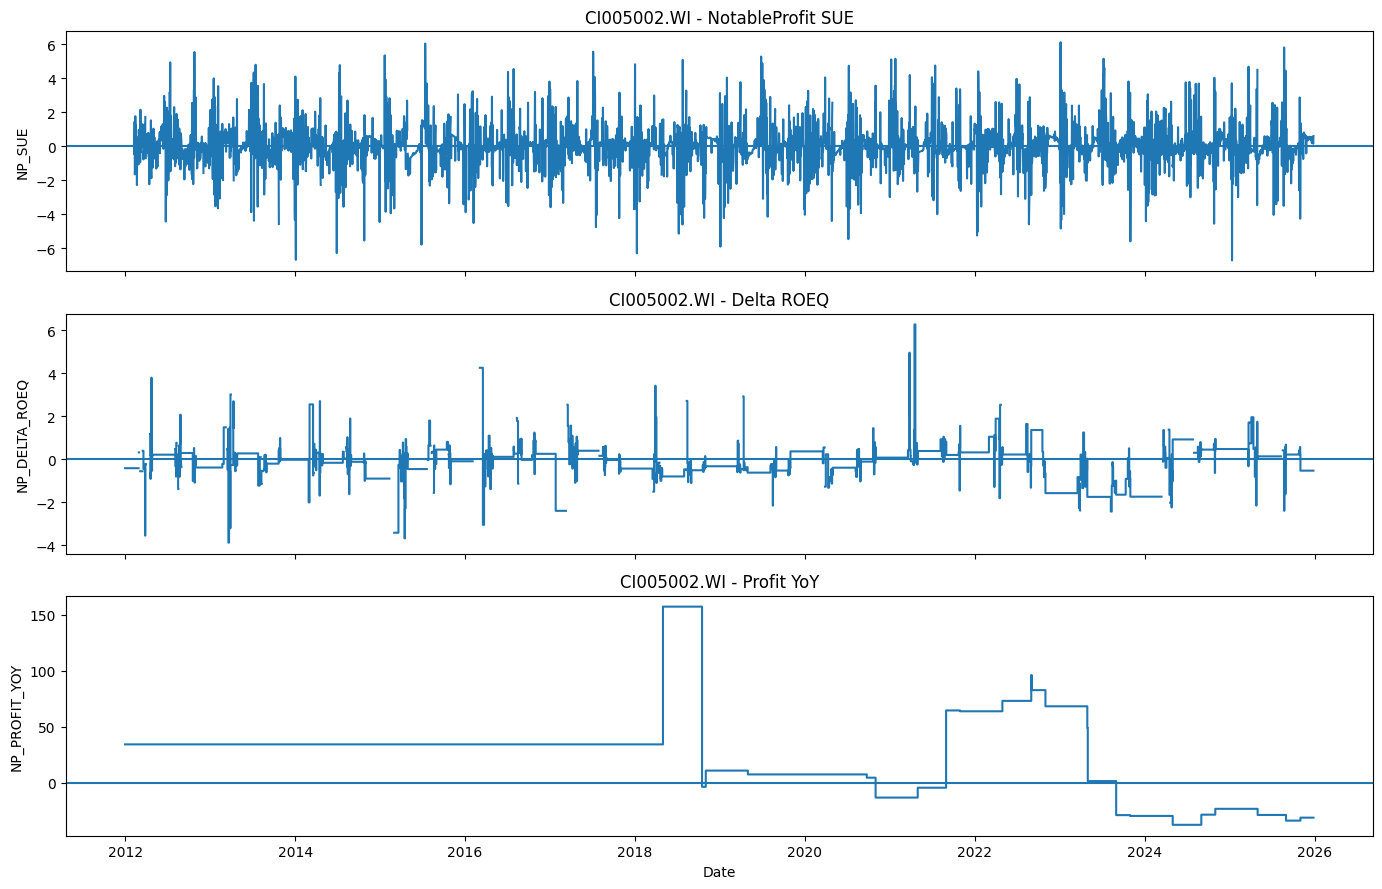

In [19]:
ind_code = "CI005002.WI"

df = (
    df_np[df_np["INDEX_CODE"] == ind_code]
    .sort_values("dt")
    .copy()
)

fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# SUE
axes[0].plot(df["dt"], df["NP_SUE"])
axes[0].axhline(0)
axes[0].set_title(f"{ind_code} - NotableProfit SUE")
axes[0].set_ylabel("NP_SUE")

# Delta ROEQ
axes[1].plot(df["dt"], df["NP_DELTA_ROEQ"], drawstyle="steps-post")
axes[1].axhline(0)
axes[1].set_title(f"{ind_code} - Delta ROEQ")
axes[1].set_ylabel("NP_DELTA_ROEQ")

# Profit YoY
axes[2].plot(df["dt"], df["NP_PROFIT_YOY"], drawstyle="steps-post")
axes[2].axhline(0)
axes[2].set_title(f"{ind_code} - Profit YoY")
axes[2].set_ylabel("NP_PROFIT_YOY")
axes[2].set_xlabel("Date")

plt.tight_layout()
plt.show()

## 计算CANSLIM：Smart

In [ ]:
START_DT = 20130101
WIN = 252
MINP = 60
MV_LOOKBACK_START = 20100101

TARGET_INDEX = "CI005002.WI"

In [ ]:
def zscore_rolling(s: pd.Series, win: int, minp: int) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    m = s.rolling(win, min_periods=minp).mean()
    sd = s.rolling(win, min_periods=minp).std()
    return (s - m) / sd

In [ ]:
# SMART 计算函数
def compute_smart_for_one_index(
    con,
    index_code: str,
    start_dt: int,
    win: int = 252,
    minp: int = 60,
    mv_lookback_start: int = 20100101,
) -> pd.DataFrame:

    warmup_start = min(int(mv_lookback_start), int(start_dt))

    # 指数成分
    sql_mem = f"""
    SELECT
        S_INFO_WINDCODE AS INDEX_CODE,
        S_CON_WINDCODE  AS STOCK_CODE,
        S_CON_INDATE    AS ENTRY_DT,
        S_CON_OUTDATE   AS REMOVE_DT
    FROM WIND.AINDEXMEMBERSCITICS
    WHERE S_INFO_WINDCODE = '{index_code}'
    """
    mem = pd.read_sql(sql_mem, con)
    if mem.empty:
        return pd.DataFrame()

    mem["STOCK_CODE"] = mem["STOCK_CODE"].astype(str)
    mem["ENTRY_DT"] = pd.to_numeric(mem["ENTRY_DT"], errors="coerce").fillna(0).astype(int)
    mem["REMOVE_DT"] = pd.to_numeric(mem["REMOVE_DT"], errors="coerce").fillna(99991231).astype(int)

    stock_tuple = tuple(mem["STOCK_CODE"].unique().tolist())
    stock_tuple_str = "(" + ",".join([f"'{x}'" for x in stock_tuple]) + ")"

    # 资金流
    sql_mf = f"""
    SELECT
        S_INFO_WINDCODE AS STOCK_CODE,
        TO_NUMBER(TRADE_DT) AS TRADE_DT,
        BUY_VALUE_EXLARGE_ORDER  AS BUY_EXL,
        BUY_VALUE_LARGE_ORDER    AS BUY_L,
        SELL_VALUE_EXLARGE_ORDER AS SELL_EXL,
        SELL_VALUE_LARGE_ORDER   AS SELL_L
    FROM WIND.ASHAREMONEYFLOW
    WHERE TO_NUMBER(TRADE_DT) >= {warmup_start}
      AND S_INFO_WINDCODE IN {stock_tuple_str}
    """
    mf = pd.read_sql(sql_mf, con)
    if mf.empty:
        return pd.DataFrame()

    mf["TRADE_DT"] = pd.to_numeric(mf["TRADE_DT"], errors="coerce").astype("Int64")
    mf = mf.dropna(subset=["TRADE_DT"]).copy()
    mf["TRADE_DT"] = mf["TRADE_DT"].astype(int)

    mf = mf.merge(mem[["STOCK_CODE", "ENTRY_DT", "REMOVE_DT"]], on="STOCK_CODE", how="inner")
    mf = mf[(mf["TRADE_DT"] >= mf["ENTRY_DT"]) & (mf["TRADE_DT"] <= mf["REMOVE_DT"])].copy()

    for c in ["BUY_EXL", "BUY_L", "SELL_EXL", "SELL_L"]:
        mf[c] = pd.to_numeric(mf[c], errors="coerce").fillna(0.0)

    mf["NET_LARGE_VALUE"] = mf["BUY_EXL"] + mf["BUY_L"] - mf["SELL_EXL"] - mf["SELL_L"]

    # 自由流通市值
    sql_mv = f"""
    SELECT
        S_INFO_WINDCODE AS STOCK_CODE,
        TO_NUMBER(TRADE_DT) AS TRADE_DT,
        S_DFA_FLOATMV AS FLOAT_MV
    FROM WIND.DAILYVALUATIONFACTOR
    WHERE TO_NUMBER(TRADE_DT) >= {warmup_start}
      AND S_INFO_WINDCODE IN {stock_tuple_str}
    """
    mv = pd.read_sql(sql_mv, con)
    if mv.empty:
        return pd.DataFrame()

    mv["TRADE_DT"] = pd.to_numeric(mv["TRADE_DT"], errors="coerce").astype("Int64")
    mv = mv.dropna(subset=["TRADE_DT"]).copy()
    mv["TRADE_DT"] = mv["TRADE_DT"].astype(int)
    mv["FLOAT_MV"] = pd.to_numeric(mv["FLOAT_MV"], errors="coerce")

    df = mf.merge(mv, on=["STOCK_CODE", "TRADE_DT"], how="left").sort_values(["STOCK_CODE", "TRADE_DT"])
    df["FLOAT_MV"] = df.groupby("STOCK_CODE")["FLOAT_MV"].ffill()
    df.loc[df["FLOAT_MV"] <= 0, "FLOAT_MV"] = np.nan

    df["SMART_STOCK"] = df["NET_LARGE_VALUE"] / df["FLOAT_MV"]

    smart_daily = (
        df.groupby("TRADE_DT", as_index=False)
          .agg(
              SMART_RAW=("SMART_STOCK", "mean"),
              N_STOCK=("SMART_STOCK", lambda s: s.notna().sum())
          )
          .sort_values("TRADE_DT")
    )

    smart_daily["SMART"] = zscore_rolling(smart_daily["SMART_RAW"], win, minp)
    smart_daily = smart_daily[smart_daily["TRADE_DT"] >= int(start_dt)].copy()
    smart_daily["INDEX_CODE"] = index_code

    return smart_daily[["INDEX_CODE", "TRADE_DT", "SMART_RAW", "N_STOCK", "SMART"]]

==> computing CI005001.WI ...
rows = 3154 nan_ratio = 0.0
==> computing CI005002.WI ...
rows = 3154 nan_ratio = 0.0
==> computing CI005003.WI ...
rows = 3154 nan_ratio = 0.0
smart_df shape: (9462, 5)


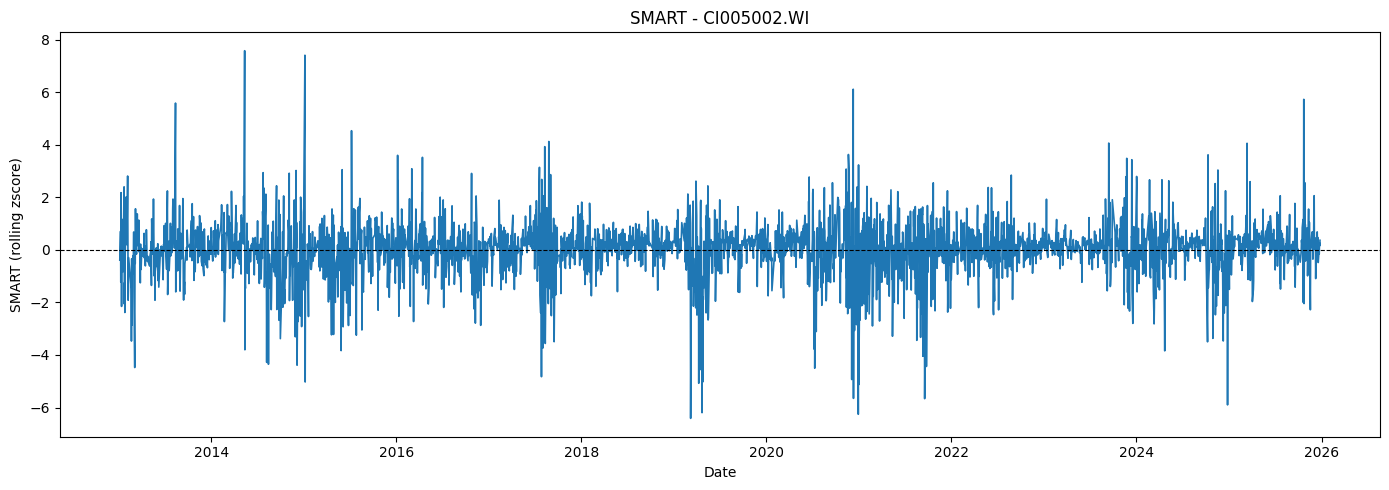

In [20]:
all_res = []
for idx in cics_level1:
    print(f"==> computing {idx} ...")
    one = compute_smart_for_one_index(
        con, idx,
        start_dt=START_DT,
        win=WIN,
        minp=MINP,
        mv_lookback_start=MV_LOOKBACK_START
    )
    print("rows =", len(one), "nan_ratio =", (one["SMART"].isna().mean() if len(one) else np.nan))
    all_res.append(one)

smart_df = pd.concat(all_res, ignore_index=True)
print("smart_df shape:", smart_df.shape)

In [ ]:
one_ind = smart_df[smart_df["INDEX_CODE"] == TARGET_INDEX].sort_values("TRADE_DT").copy()
one_ind["dt"] = pd.to_datetime(one_ind["TRADE_DT"].astype(str))

plt.figure(figsize=(14, 5))
plt.plot(one_ind["dt"], one_ind["SMART"], linewidth=1.2)
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title(f"SMART - {TARGET_INDEX}")
plt.xlabel("Date")
plt.ylabel("SMART (rolling zscore)")
plt.tight_layout()
plt.show()

## 计算CANSLIM：Leader

In [21]:
START_DT = 20120104
START_DT_TARGET = 20130104
END_DT = 20250930

PARAMS = dict(
    top_n=10,
    lag_days=45,
    z_win=252,
    z_minp=60,
    flow_field="VOLUME_DIFF_INSTITUTE",
    min_active=10,
    anchor_code="000001.SZ",
)

def zscore_rolling(s, win=252, minp=60):
    mu = s.rolling(win, min_periods=minp).mean()
    sd = s.rolling(win, min_periods=minp).std(ddof=0)
    return (s - mu) / sd.replace(0, np.nan)

def chunked(xs, n=800):
    xs = list(xs)
    for i in range(0, len(xs), n):
        yield xs[i:i+n]

def to_dt_int(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (pd.Timestamp, np.datetime64)):
        return int(pd.to_datetime(x).strftime("%Y%m%d"))
    s = str(x).strip()
    if s.isdigit() and len(s) == 8:
        return int(s)
    return int(pd.to_datetime(s, errors="coerce").strftime("%Y%m%d"))

In [22]:
def load_trading_days(con, anchor_code, start_dt, end_dt):
    sql = f"""
    SELECT TRADE_DT
    FROM WIND.ASHAREEODPRICES
    WHERE S_INFO_WINDCODE = '{anchor_code}'
      AND TRADE_DT BETWEEN {int(start_dt)} AND {int(end_dt)}
    ORDER BY TRADE_DT
    """
    td = pd.read_sql(sql, con)["TRADE_DT"]
    td = td.map(to_dt_int).dropna().astype(int).to_numpy()
    return td

def next_trading_day(trading_days, dt_int):
    i = np.searchsorted(trading_days, int(dt_int), side="left")
    return None if i >= len(trading_days) else int(trading_days[i])

def load_available_report_dates(con, start_dt, end_dt):
    sql = f"""
    SELECT DISTINCT F_PRT_ENDDATE AS REPORT_DT
    FROM WIND.CHINAMUTUALFUNDSTOCKPORTFOLIO
    WHERE F_PRT_ENDDATE BETWEEN {int(start_dt)} AND {int(end_dt)}
    ORDER BY F_PRT_ENDDATE
    """
    r = pd.read_sql(sql, con)["REPORT_DT"].dropna().astype(int).to_numpy()
    return r

def latest_available_report_dt(avail_reports, want_dt):
    i = np.searchsorted(avail_reports, int(want_dt), side="right") - 1
    return None if i < 0 else int(avail_reports[i])

def build_quarter_ends(start_year, end_year):
    q = ("0331","0630","0930","1231")
    return [int(f"{y}{m}") for y in range(start_year, end_year+1) for m in q]

def get_index_members(con, index_code):
    sql = f"""
    SELECT
      S_CON_WINDCODE AS STOCK_CODE,
      TO_NUMBER(S_CON_INDATE) AS ENTRY_DT,
      NVL(TO_NUMBER(S_CON_OUTDATE), 99991231) AS REMOVE_DT
    FROM WIND.AINDEXMEMBERSCITICS
    WHERE S_INFO_WINDCODE = '{index_code}'
    """
    mem = pd.read_sql(sql, con)
    if mem.empty:
        return mem
    mem["STOCK_CODE"] = mem["STOCK_CODE"].astype(str)
    mem["ENTRY_DT"] = mem["ENTRY_DT"].astype(int)
    mem["REMOVE_DT"] = mem["REMOVE_DT"].astype(int)
    return mem

def get_stock_ret(con, codes, start_dt, end_dt):
    if not codes:
        return pd.DataFrame(columns=["TRADE_DT","STOCK_CODE","RET"])
    out = []
    for part in chunked(sorted(set(codes)), 800):
        code_in = "(" + ",".join([f"'{c}'" for c in part]) + ")"
        sql = f"""
        SELECT
          TO_NUMBER(TRADE_DT) AS TRADE_DT,
          S_INFO_WINDCODE AS STOCK_CODE,
          S_DQ_PCTCHANGE AS RET_PCT
        FROM WIND.ASHAREEODPRICES
        WHERE S_INFO_WINDCODE IN {code_in}
          AND TO_NUMBER(TRADE_DT) BETWEEN {int(start_dt)} AND {int(end_dt)}
          AND S_DQ_PCTCHANGE > -99.99
        """
        out.append(pd.read_sql(sql, con))
    df = pd.concat(out, ignore_index=True)
    df["TRADE_DT"] = df["TRADE_DT"].astype(int)
    df["STOCK_CODE"] = df["STOCK_CODE"].astype(str)
    df["RET"] = pd.to_numeric(df["RET_PCT"], errors="coerce") / 100.0
    return df[["TRADE_DT","STOCK_CODE","RET"]]

def get_stock_flow(con, codes, start_dt, end_dt, field):
    if not codes:
        return pd.DataFrame(columns=["TRADE_DT","STOCK_CODE","FLOW"])
    out = []
    for part in chunked(sorted(set(codes)), 800):
        code_in = "(" + ",".join([f"'{c}'" for c in part]) + ")"
        sql = f"""
        SELECT
          TO_NUMBER(TRADE_DT) AS TRADE_DT,
          S_INFO_WINDCODE AS STOCK_CODE,
          {field} AS FLOW
        FROM WIND.ASHAREMONEYFLOW
        WHERE S_INFO_WINDCODE IN {code_in}
          AND TO_NUMBER(TRADE_DT) BETWEEN {int(start_dt)} AND {int(end_dt)}
        """
        out.append(pd.read_sql(sql, con))
    df = pd.concat(out, ignore_index=True)
    df["TRADE_DT"] = df["TRADE_DT"].astype(int)
    df["STOCK_CODE"] = df["STOCK_CODE"].astype(str)
    df["FLOW"] = pd.to_numeric(df["FLOW"], errors="coerce")
    return df[["TRADE_DT","STOCK_CODE","FLOW"]]

def load_heavy_topN_by_report_industry(con, index_code, report_dates, top_n):
    rds = sorted(set(int(x) for x in report_dates))
    if not rds:
        return {}

    rd_in = "(" + ",".join(map(str, rds)) + ")"
    sql = f"""
    SELECT
      P.F_PRT_ENDDATE AS REPORT_DT,
      P.S_INFO_STOCKWINDCODE AS STOCK_CODE,
      SUM(P.F_PRT_STKVALUE) AS STKVALUE
    FROM WIND.CHINAMUTUALFUNDSTOCKPORTFOLIO P
    JOIN WIND.AINDEXMEMBERSCITICS M
      ON M.S_INFO_WINDCODE = '{index_code}'
     AND M.S_CON_WINDCODE = P.S_INFO_STOCKWINDCODE
     AND TO_NUMBER(M.S_CON_INDATE) <= P.F_PRT_ENDDATE
     AND (M.S_CON_OUTDATE IS NULL OR TO_NUMBER(M.S_CON_OUTDATE) >= P.F_PRT_ENDDATE)
    WHERE P.F_PRT_ENDDATE IN {rd_in}
    GROUP BY P.F_PRT_ENDDATE, P.S_INFO_STOCKWINDCODE
    """
    df = pd.read_sql(sql, con)
    if df.empty:
        return {}

    df["REPORT_DT"] = df["REPORT_DT"].astype(int)
    df["STOCK_CODE"] = df["STOCK_CODE"].astype(str)
    df["STKVALUE"] = pd.to_numeric(df["STKVALUE"], errors="coerce")
    df = df.dropna(subset=["STKVALUE"])

    heavy = {}
    for rd, g in df.groupby("REPORT_DT", sort=True):
        s = g["STKVALUE"].sum()
        if s <= 0:
            heavy[int(rd)] = []
        else:
            g2 = g.assign(W=g["STKVALUE"]/s).sort_values("W", ascending=False)
            heavy[int(rd)] = g2["STOCK_CODE"].head(int(top_n)).tolist()
    return heavy

def calc_pm(ret_mat, all_codes, quarter_ends, avail_reports, trading_days, heavy_dict,
            start_dt, end_dt, lag_days, z_win, z_minp):

    pairs = []
    for q in quarter_ends:
        rd = latest_available_report_dt(avail_reports, q)
        if rd is None:
            continue

        eff_guess = int((pd.to_datetime(str(rd)) + pd.Timedelta(days=int(lag_days))).strftime("%Y%m%d"))
        eff = next_trading_day(trading_days, eff_guess)

        if eff is not None:
            pairs.append((int(rd), int(eff)))

    if not pairs:
        return pd.DataFrame(columns=["TRADE_DT","PM_RAW","PM","REPORT_DT","EFF_DT"])

    pairs = sorted(pairs, key=lambda x: (x[1], x[0]))
    eff_map = {}
    for rd, eff in pairs:
        eff_map.setdefault(eff, rd)
    eff_list = sorted([(rd, eff) for eff, rd in eff_map.items()], key=lambda x: x[1])

    out = []
    idx = ret_mat.index.astype(int)

    for i, (rd, eff) in enumerate(eff_list):
        seg_start = max(eff, int(start_dt))
        seg_end = int(end_dt) if i == len(eff_list)-1 else min(eff_list[i+1][1]-1, int(end_dt))
        if seg_start > seg_end:
            continue

        m = ret_mat.loc[(idx >= seg_start) & (idx <= seg_end)]
        if m.empty:
            continue

        heavy_codes = sorted(set(heavy_dict.get(int(rd), [])) & set(all_codes))
        if not heavy_codes:
            continue

        cumret = (1.0 + m.fillna(0.0)).cumprod(axis=0) - 1.0
        all_mean = cumret.mean(axis=1, skipna=True)
        heavy_mean = cumret[heavy_codes].mean(axis=1, skipna=True)

        tmp = (heavy_mean - all_mean).rename("PM_RAW").to_frame()
        tmp["REPORT_DT"] = int(rd)
        tmp["EFF_DT"] = int(eff)
        tmp = tmp.reset_index().rename(columns={"index":"TRADE_DT"})
        out.append(tmp)

    if not out:
        return pd.DataFrame(columns=["TRADE_DT","PM_RAW","PM","REPORT_DT","EFF_DT"])

    res = (pd.concat(out, ignore_index=True)
             .drop_duplicates("TRADE_DT")
             .sort_values("TRADE_DT"))

    res["PM"] = zscore_rolling(res["PM_RAW"], win=z_win, minp=z_minp)
    return res

def calc_va(flow_mat, min_active, z_win, z_minp):
    mu = flow_mat.mean(axis=1, skipna=True)
    sd = flow_mat.std(axis=1, skipna=True, ddof=0)
    n_active = flow_mat.notna().sum(axis=1)

    va_raw = (mu / sd).rename("VA_RAW").to_frame()
    va_raw["MU_FLOW"] = mu.values
    va_raw["SD_FLOW"] = sd.values
    va_raw["N_ACTIVE"] = n_active.values

    va_raw.loc[va_raw["N_ACTIVE"] < int(min_active), "VA_RAW"] = np.nan
    va_raw["VA"] = zscore_rolling(va_raw["VA_RAW"], win=z_win, minp=z_minp)

    return va_raw.reset_index().rename(columns={"index":"TRADE_DT"})

def calc_leader_for_one(con, index_code, start_dt, end_dt, params, trading_days, avail_reports, report_dates):
    mem = get_index_members(con, index_code)
    if mem.empty:
        return pd.DataFrame()

    all_codes = sorted(mem["STOCK_CODE"].unique().tolist())

    ret_df = get_stock_ret(con, all_codes, start_dt, end_dt)
    ret_mat = ret_df.pivot_table(index="TRADE_DT", columns="STOCK_CODE", values="RET", aggfunc="first").sort_index()

    flow_df = get_stock_flow(con, all_codes, start_dt, end_dt, field=params["flow_field"])
    flow_mat = flow_df.pivot_table(index="TRADE_DT", columns="STOCK_CODE", values="FLOW", aggfunc="first").sort_index()

    heavy_dict = load_heavy_topN_by_report_industry(con, index_code, report_dates, top_n=params["top_n"])

    pm = calc_pm(
        ret_mat=ret_mat,
        all_codes=all_codes,
        quarter_ends=report_dates,
        avail_reports=avail_reports,
        trading_days=trading_days,
        heavy_dict=heavy_dict,
        start_dt=start_dt,
        end_dt=end_dt,
        lag_days=params["lag_days"],
        z_win=params["z_win"],
        z_minp=params["z_minp"],
    )

    va = calc_va(
        flow_mat=flow_mat,
        min_active=params["min_active"],
        z_win=params["z_win"],
        z_minp=params["z_minp"],
    )

    out = pd.merge(pm, va, on="TRADE_DT", how="outer").sort_values("TRADE_DT")
    out["INDEX_CODE"] = index_code

    dt_guess = pd.to_datetime(out["TRADE_DT"], errors="coerce")
    mask = dt_guess.isna()
    if mask.any():
        dt_guess.loc[mask] = pd.to_datetime(out.loc[mask, "TRADE_DT"].astype(str), format="%Y%m%d", errors="coerce")
    out["Date"] = dt_guess

    return out

sy, ey = int(str(START_DT)[:4]), int(str(END_DT)[:4])
report_dates = build_quarter_ends(sy, ey)

end_with_buf = int((pd.to_datetime(str(END_DT)) + pd.Timedelta(days=PARAMS["lag_days"] + 10)).strftime("%Y%m%d"))
trading_days = load_trading_days(con, PARAMS["anchor_code"], START_DT, end_with_buf)
avail_reports = load_available_report_dates(con, START_DT, END_DT)

In [23]:
leader_list, bad = [], []
for idx in cics_level1:
    try:
        df_one = calc_leader_for_one(con, idx, START_DT, END_DT, PARAMS, trading_days, avail_reports, report_dates)
        if df_one.empty:
            bad.append((idx, "empty"))
            continue

        df_one = df_one[(df_one["TRADE_DT"] >= START_DT_TARGET) & (df_one["TRADE_DT"] <= END_DT)].copy()
        leader_list.append(df_one[["INDEX_CODE","TRADE_DT","Date","PM","VA"]])

        print("ok", idx, "rows", len(df_one),
              "PM_na", float(df_one["PM"].isna().mean()),
              "VA_na", float(df_one["VA"].isna().mean()))

    except Exception as e:
        bad.append((idx, str(e)))
        print("[ERROR]", idx, e)

leader_all = (pd.concat(leader_list, ignore_index=True)
                .sort_values(["INDEX_CODE","TRADE_DT"])
                .reset_index(drop=True))

print("done. industries:", leader_all["INDEX_CODE"].nunique(), "rows:", len(leader_all))

ok CI005001.WI rows 3097 PM_na 0.0 VA_na 0.0
ok CI005002.WI rows 3097 PM_na 0.0 VA_na 0.0
ok CI005003.WI rows 3097 PM_na 0.0 VA_na 0.0
done. industries: 3 rows: 9291


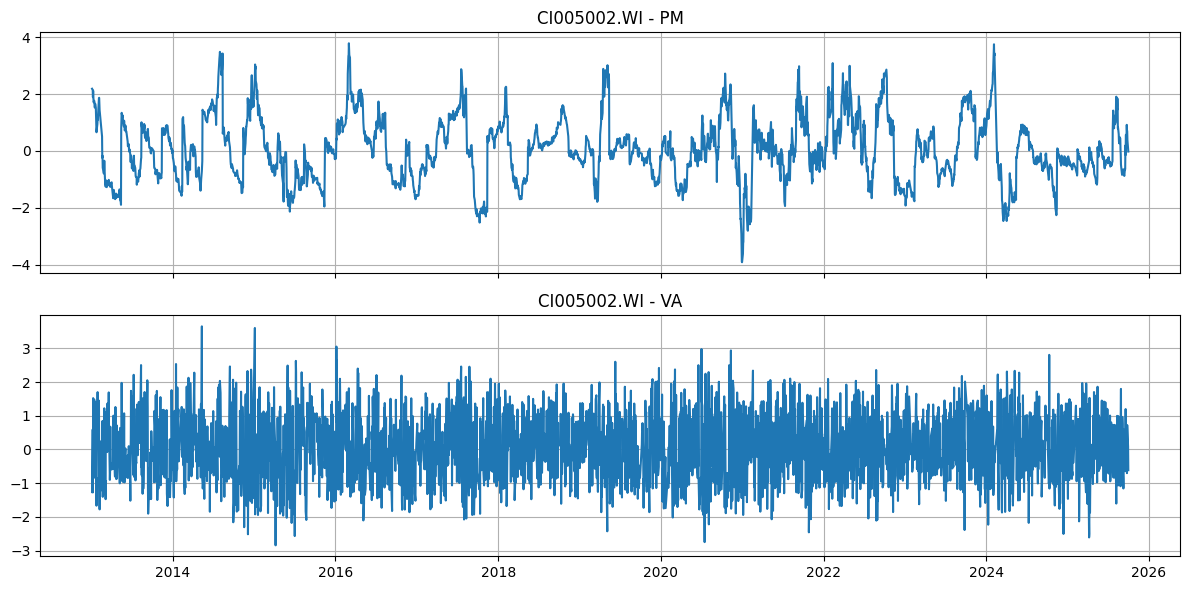

In [24]:
idx = "CI005002.WI"
df_plot = leader_all[leader_all["INDEX_CODE"] == idx].copy()

x = pd.to_datetime(df_plot["TRADE_DT"].astype(str), format="%Y%m%d")
df_plot = df_plot.assign(_x=x).sort_values("_x")

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
axes[0].plot(df_plot["_x"], df_plot["PM"]); axes[0].set_title(f"{idx} - PM"); axes[0].grid(True)
axes[1].plot(df_plot["_x"], df_plot["VA"]); axes[1].set_title(f"{idx} - VA"); axes[1].grid(True)
plt.tight_layout()
plt.show()

## 计算CANSLIM：Institution

In [25]:
START_DT_TARGET = 20121231
END_DT = 20250930
START_DT_UNDER_FETCH = 20120101
START_DT_SELLSIDE_FETCH = 20120101

def to_dt(x):
    return pd.to_datetime(str(int(x)), format="%Y%m%d")

# 返回 [start_dt, end_dt] 之间的所有月末 Timestamp
def month_ends(start_dt, end_dt):
    start = to_dt(start_dt)
    end = to_dt(end_dt)
    return pd.date_range(start, end, freq="M")
    
# 同一日期内做归一化：w / sum(w)
def _norm_by_date(df, dt_col, w_col, out_col=None):
    out_col = out_col or w_col
    s = df.groupby(dt_col, as_index=False)[w_col].sum().rename(columns={w_col: "_S"})
    df = df.merge(s, on=dt_col, how="left")
    df[out_col] = np.where(df["_S"] > 0, df[w_col] / df["_S"], np.nan)
    return df.drop(columns=["_S"])

In [26]:
def fetch_sellside_ratings(con, start_dt, end_dt,
                          positive_keywords=("买入","推荐","增持","强烈推荐"),
                          default_valid_days=180):
    kw_list = list(positive_keywords)
    kw_binds = ",".join([f":kw{i}" for i in range(len(kw_list))])

    sql = f"""
    SELECT
        S_INFO_WINDCODE        AS STOCK_CODE,
        S_EST_INSTITUTE        AS BROKER,
        S_EST_RATING_INST      AS RATING,
        CASE
            WHEN ANN_DT IS NOT NULL THEN TO_DATE(ANN_DT, 'YYYYMMDD')
            ELSE OPDATE
        END                    AS EVENT_DT,
        CASE
            WHEN S_RATING_VALIDENDDT IS NOT NULL THEN TO_DATE(S_RATING_VALIDENDDT, 'YYYYMMDD')
            ELSE (CASE WHEN ANN_DT IS NOT NULL THEN TO_DATE(ANN_DT,'YYYYMMDD') ELSE OPDATE END) + :default_valid_days
        END                    AS VALID_END_DT
    FROM WIND.ASHARESTOCKRATING
    WHERE S_INFO_WINDCODE IS NOT NULL
      AND S_EST_INSTITUTE IS NOT NULL
      AND S_EST_RATING_INST IN ({kw_binds})
      AND (CASE WHEN ANN_DT IS NOT NULL THEN TO_DATE(ANN_DT,'YYYYMMDD') ELSE OPDATE END) <= TO_DATE(:end_dt,'YYYYMMDD')
      AND (
            CASE
              WHEN S_RATING_VALIDENDDT IS NOT NULL THEN TO_DATE(S_RATING_VALIDENDDT,'YYYYMMDD')
              ELSE (CASE WHEN ANN_DT IS NOT NULL THEN TO_DATE(ANN_DT,'YYYYMMDD') ELSE OPDATE END) + :default_valid_days
            END
          ) >= TO_DATE(:start_dt,'YYYYMMDD')
    """

    params = {"start_dt": str(int(start_dt)),
              "end_dt": str(int(end_dt)),
              "default_valid_days": int(default_valid_days)}
    params.update({f"kw{i}": kw_list[i] for i in range(len(kw_list))})

    df = pd.read_sql(sql, con, params=params)
    df["STOCK_CODE"] = df["STOCK_CODE"].astype(str)
    df["BROKER"] = df["BROKER"].astype(str)
    df["RATING"] = df["RATING"].astype(str)
    df["EVENT_DT"] = pd.to_datetime(df["EVENT_DT"])
    df["VALID_END_DT"] = pd.to_datetime(df["VALID_END_DT"])
    return df

# 股票 -> 行业指数 的成分映射
def fetch_citics_membership(con, ind_prefix="CI00"):
    sql = f"""
    SELECT
        S_INFO_WINDCODE AS IND_CODE,
        S_CON_WINDCODE  AS STOCK_CODE,
        S_CON_INDATE    AS INDATE,
        S_CON_OUTDATE   AS OUTDATE
    FROM WIND.AINDEXMEMBERSCITICS
    WHERE S_INFO_WINDCODE LIKE '{ind_prefix}%.WI'
    """
    m = pd.read_sql(sql, con)
    m["IND_CODE"] = m["IND_CODE"].astype(str)
    m["STOCK_CODE"] = m["STOCK_CODE"].astype(str)
    m["INDATE"] = pd.to_numeric(m["INDATE"], errors="coerce")
    m["OUTDATE"] = pd.to_numeric(m["OUTDATE"], errors="coerce")
    # 空值填成超大/超小，便于用 int 比较
    m["INDATE"] = m["INDATE"].fillna(19000101).astype(int)
    m["OUTDATE"] = m["OUTDATE"].fillna(29991231).astype(int)
    return m


def build_monthly_consensus_share(ratings, membership, start_dt, end_dt, n_min_brokers=3):
    mes = month_ends(start_dt, end_dt)
    mem = membership.copy()

    out = []
    for me in mes:
        me_int = int(me.strftime("%Y%m%d"))

        eff = ratings[(ratings["EVENT_DT"] <= me) & (ratings["VALID_END_DT"] >= me)]
        if eff.empty:
            continue

        cnt = eff.groupby("STOCK_CODE")["BROKER"].nunique().reset_index(name="N_BROKERS")
        pool = cnt[cnt["N_BROKERS"] >= n_min_brokers][["STOCK_CODE"]]
        if pool.empty:
            continue

        mem_eff = mem[(mem["INDATE"] <= me_int) & (mem["OUTDATE"] > me_int)][["STOCK_CODE", "IND_CODE"]]
        if mem_eff.empty:
            continue

        pool_map = pool.merge(mem_eff, on="STOCK_CODE", how="inner").drop_duplicates()
        n_total = pool["STOCK_CODE"].nunique()
        if n_total == 0 or pool_map.empty:
            continue

        g = pool_map.groupby("IND_CODE")["STOCK_CODE"].nunique().reset_index(name="N_POOL_STOCK")
        g["N_POOL_TOTAL"] = n_total
        g["MONTH_END"] = me
        g["MONTH_END_INT"] = me_int
        g["SHARE"] = g["N_POOL_STOCK"] / g["N_POOL_TOTAL"]
        out.append(g)

    if not out:
        return pd.DataFrame(columns=["IND_CODE","MONTH_END","MONTH_END_INT","N_POOL_STOCK","N_POOL_TOTAL","SHARE","SHARE_CHG"])

    df = pd.concat(out, ignore_index=True).sort_values(["IND_CODE","MONTH_END"]).reset_index(drop=True)
    df["SHARE_CHG"] = df.groupby("IND_CODE")["SHARE"].diff()
    df.loc[df.groupby("IND_CODE").cumcount() == 0, "SHARE_CHG"] = np.nan
    return df

In [27]:
def get_report_dates(con, start_dt, end_dt, freq="Q"):
    freq_map = {"Q": ["季报"], "S": ["中报"], "A": ["年报"], "ALL": None}
    types = freq_map.get(freq, ["季报"])
    where_type = "" if types is None else " AND REPORT_TYPE IN (" + ",".join([f"'{t}'" for t in types]) + ") "

    sql = f"""
    SELECT DISTINCT F_PRT_ENDDATE AS REPORT_DT
    FROM WIND.CHINAMUTUALFUNDSTOCKPORTFOLIO
    WHERE F_PRT_ENDDATE BETWEEN {int(start_dt)} AND {int(end_dt)}
      AND F_PRT_ENDDATE IS NOT NULL
      {where_type}
    ORDER BY F_PRT_ENDDATE
    """
    r = pd.read_sql(sql, con)
    return r["REPORT_DT"].dropna().astype(int).tolist()

def load_fund_w(con, report_dates, ind_prefix="CI00"):
    rd_in = ",".join([str(int(x)) for x in report_dates])

    sql = f"""
    SELECT
        P.F_PRT_ENDDATE AS REPORT_DT,
        M.S_INFO_WINDCODE AS IND_CODE,
        SUM(P.F_PRT_STKVALUETONAV) AS FUND_W
    FROM WIND.CHINAMUTUALFUNDSTOCKPORTFOLIO P
    JOIN WIND.AINDEXMEMBERSCITICS M
      ON M.S_CON_WINDCODE = P.S_INFO_STOCKWINDCODE
     AND M.S_INFO_WINDCODE LIKE '{ind_prefix}%.WI'
     AND TO_NUMBER(M.S_CON_INDATE) <= P.F_PRT_ENDDATE
     AND (M.S_CON_OUTDATE IS NULL OR TO_NUMBER(M.S_CON_OUTDATE) > P.F_PRT_ENDDATE)
    WHERE P.F_PRT_ENDDATE IN ({rd_in})
      AND P.F_PRT_STKVALUETONAV IS NOT NULL
    GROUP BY P.F_PRT_ENDDATE, M.S_INFO_WINDCODE
    """
    df = pd.read_sql(sql, con)
    df["REPORT_DT"] = df["REPORT_DT"].astype(int)
    df["IND_CODE"] = df["IND_CODE"].astype(str)
    df["FUND_W"] = pd.to_numeric(df["FUND_W"], errors="coerce")
    df = df.dropna(subset=["FUND_W"])
    return _norm_by_date(df, "REPORT_DT", "FUND_W")[["REPORT_DT","IND_CODE","FUND_W"]]

def load_bench_w(con, report_dates, ind_prefix="CI00", bench_index="000906.SH", mv_field="S_DQ_MV"):
    rd_in = ",".join([str(int(x)) for x in report_dates])

    sql = f"""
    WITH idx AS (
        SELECT S_CON_WINDCODE AS STOCK_CODE, S_CON_INDATE, S_CON_OUTDATE
        FROM WIND.AINDEXMEMBERS
        WHERE S_INFO_WINDCODE = '{bench_index}'
    ),
    indmap AS (
        SELECT S_INFO_WINDCODE AS IND_CODE, S_CON_WINDCODE AS STOCK_CODE, S_CON_INDATE, S_CON_OUTDATE
        FROM WIND.AINDEXMEMBERSCITICS
        WHERE S_INFO_WINDCODE LIKE '{ind_prefix}%.WI'
    ),
    mv AS (
        SELECT TRADE_DT AS REPORT_DT, S_INFO_WINDCODE AS STOCK_CODE, {mv_field} AS MV
        FROM WIND.ASHAREEODDERIVATIVEINDICATOR
        WHERE TRADE_DT IN ({rd_in})
    )
    SELECT mv.REPORT_DT, im.IND_CODE, SUM(mv.MV) AS BENCH_W
    FROM mv
    JOIN idx
      ON idx.STOCK_CODE = mv.STOCK_CODE
     AND TO_NUMBER(idx.S_CON_INDATE) <= mv.REPORT_DT
     AND (idx.S_CON_OUTDATE IS NULL OR TO_NUMBER(idx.S_CON_OUTDATE) > mv.REPORT_DT)
    JOIN indmap im
      ON im.STOCK_CODE = mv.STOCK_CODE
     AND TO_NUMBER(im.S_CON_INDATE) <= mv.REPORT_DT
     AND (im.S_CON_OUTDATE IS NULL OR TO_NUMBER(im.S_CON_OUTDATE) > mv.REPORT_DT)
    WHERE mv.MV IS NOT NULL
    GROUP BY mv.REPORT_DT, im.IND_CODE
    """
    df = pd.read_sql(sql, con)
    df["REPORT_DT"] = df["REPORT_DT"].astype(int)
    df["IND_CODE"] = df["IND_CODE"].astype(str)
    df["BENCH_W"] = pd.to_numeric(df["BENCH_W"], errors="coerce")
    df = df.dropna(subset=["BENCH_W"])
    return _norm_by_date(df, "REPORT_DT", "BENCH_W")[["REPORT_DT","IND_CODE","BENCH_W"]]

def build_quarterly_under_w(con, start_dt, end_dt, freq="Q",
                           ind_prefix="CI00", bench_index="000906.SH", mv_field="S_DQ_MV"):
    rds = get_report_dates(con, start_dt, end_dt, freq=freq)
    if not rds:
        raise ValueError("No report dates. Check start/end or REPORT_TYPE filter.")

    fund = load_fund_w(con, rds, ind_prefix=ind_prefix)
    bench = load_bench_w(con, rds, ind_prefix=ind_prefix, bench_index=bench_index, mv_field=mv_field)

    df = fund.merge(bench, on=["REPORT_DT","IND_CODE"], how="outer")
    df["FUND_W"] = df["FUND_W"].fillna(0.0)
    df["BENCH_W"] = df["BENCH_W"].fillna(0.0)
    df["UNDER_W"] = df["BENCH_W"] - df["FUND_W"]

    df = df.sort_values(["IND_CODE","REPORT_DT"]).reset_index(drop=True)
    df["D_UNDER_W"] = df.groupby("IND_CODE")["UNDER_W"].diff()
    return df, rds
    
# 把季报点扩展到每个行业的月末序列
def ffill_quarterly_to_month_end(df_q, report_dates):
    min_dt = to_dt(min(report_dates))
    max_dt = to_dt(max(report_dates))
    mes = pd.date_range(min_dt, max_dt, freq="M")

    keep = ["FUND_W","BENCH_W","UNDER_W"]
    out = []

    base = df_q.copy()
    base["DT"] = pd.to_datetime(base["REPORT_DT"].astype(str), format="%Y%m%d")

    for ind, g in base.groupby("IND_CODE"):
        g = g.sort_values("DT").set_index("DT")[keep]
        g = g.reindex(g.index.union(mes)).sort_index()
        gm = g.reindex(mes, method="ffill")
        gm["IND_CODE"] = ind
        gm["REPORT_DT"] = gm.index.strftime("%Y%m%d").astype(int)
        gm = gm.reset_index().rename(columns={"index":"DT"})
        out.append(gm)

    df_m = pd.concat(out, ignore_index=True)
    df_m = df_m.dropna(subset=["UNDER_W"]).sort_values(["IND_CODE","REPORT_DT"]).reset_index(drop=True)
    df_m["D_UNDER_W"] = df_m.groupby("IND_CODE")["UNDER_W"].diff()
    return df_m

In [28]:
def run_all(con,
            start_dt_target=START_DT_TARGET,
            end_dt=END_DT,
            start_dt_under_fetch=START_DT_UNDER_FETCH,
            start_dt_sellside_fetch=START_DT_SELLSIDE_FETCH,
            ind_prefix="CI00",
            bench_index="000906.SH",
            mv_field="S_DQ_MV",
            n_min_brokers=3):

    # Sellside share
    ratings = fetch_sellside_ratings(
        con, start_dt_sellside_fetch, end_dt,
        positive_keywords=("买入","推荐","增持","强烈推荐"),
        default_valid_days=180
    )
    membership = fetch_citics_membership(con, ind_prefix=ind_prefix)
    sellside_share_all = build_monthly_consensus_share(
        ratings, membership, start_dt_sellside_fetch, end_dt, n_min_brokers=n_min_brokers
    )
    sellside_share_all = sellside_share_all[sellside_share_all["IND_CODE"].isin(cics_level1)].reset_index(drop=True)

    # UNDER_W
    under_q, report_dates = build_quarterly_under_w(
        con, start_dt_under_fetch, end_dt,
        freq="Q", ind_prefix=ind_prefix, bench_index=bench_index, mv_field=mv_field
    )
    under_m = ffill_quarterly_to_month_end(under_q, report_dates)
    under_m = under_m[under_m["IND_CODE"].isin(cics_level1)].reset_index(drop=True)

    cut = to_dt(start_dt_target)

    sellside_share_all = sellside_share_all[sellside_share_all["MONTH_END"] >= cut].reset_index(drop=True)

    under_m["DT"] = pd.to_datetime(under_m["REPORT_DT"].astype(str), format="%Y%m%d")
    under_m = under_m[under_m["DT"] >= cut].reset_index(drop=True)

    return cics_level1, sellside_share_all, under_m

In [29]:
def plot_two_metrics(sellside_share_all, under_m, ind_code, start_dt_target=START_DT_TARGET):
    cut = to_dt(start_dt_target)

    # Sellside
    one = sellside_share_all[sellside_share_all["IND_CODE"] == ind_code].sort_values("MONTH_END").copy()
    if one.empty:
        print("[plot] sellside empty:", ind_code)
    else:
        plt.figure(figsize=(10,4))
        plt.plot(one["MONTH_END"], one["SHARE"])
        plt.title(f"{ind_code} - Sellside consensus pool industry share")
        plt.xlim(cut, None)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(one["MONTH_END"], one["SHARE_CHG"])
        plt.title(f"{ind_code} - Share change vs last month")
        plt.xlim(cut, None)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # UNDER_W
    two = under_m[under_m["IND_CODE"] == ind_code].sort_values("DT").copy()
    if two.empty:
        print("[plot] under_w empty:", ind_code)
    else:
        plt.figure(figsize=(10,4))
        plt.plot(two["DT"], two["UNDER_W"])
        plt.title(f"{ind_code} - UNDER_W (BENCH - FUND), month-end ffilled from quarterly")
        plt.xlim(cut, None)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

sellside_share_all shape: (462, 7)
under_m shape: (156, 7)


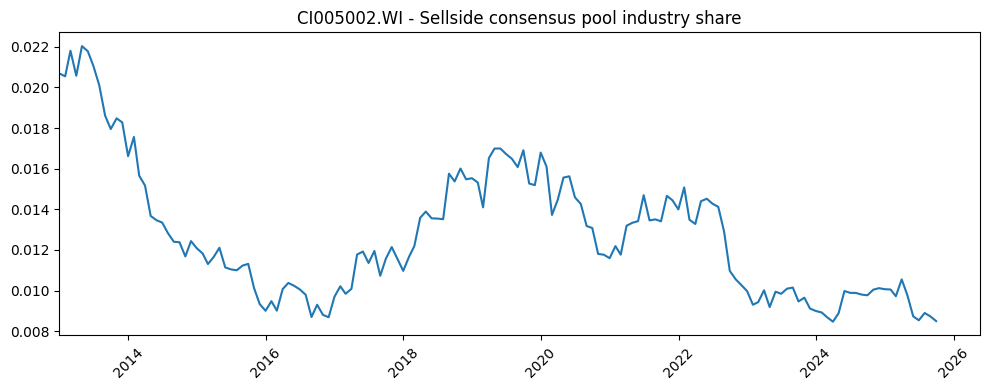

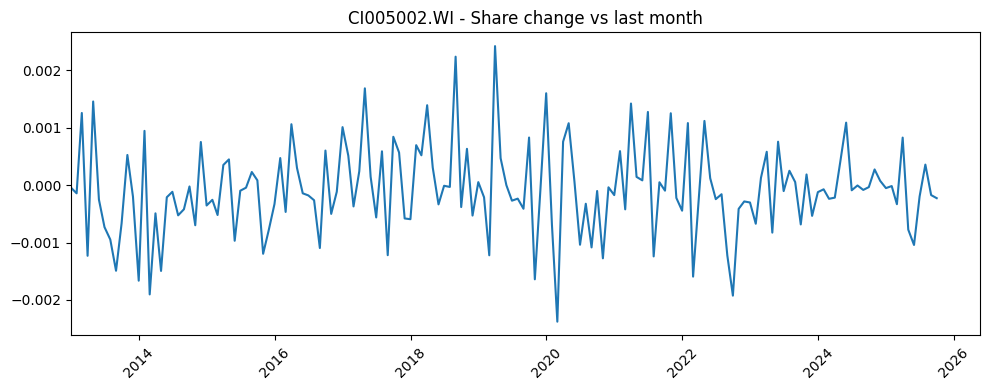

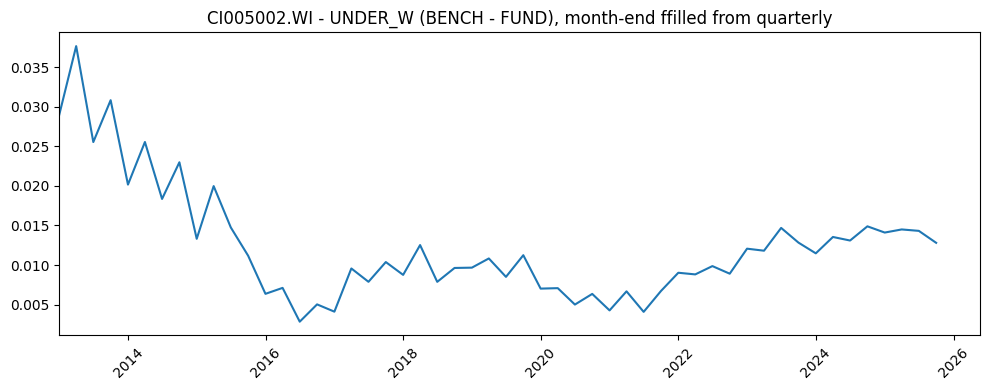

In [30]:
cics_level1, sellside_share_all, under_m = run_all(con)
print("sellside_share_all shape:", sellside_share_all.shape)
print("under_m shape:", under_m.shape)

PLOT_IND = "CI005002.WI"
plot_two_metrics(sellside_share_all, under_m, PLOT_IND)

In [160]:
# 行业卖方一致预期池
i_sellside = (
    sellside_share_all
    .rename(columns={
        "IND_CODE": "INDEX_CODE",
        "MONTH_END": "DT"
    })
    .copy()
)

i_sellside["TRADE_DT"] = i_sellside["DT"].dt.strftime("%Y%m%d").astype(int)

i_sellside = i_sellside[[
    "INDEX_CODE",
    "TRADE_DT",
    "SHARE",
    "SHARE_CHG"
]].rename(columns={
    "SHARE": "I_SELLSIDE",
    "SHARE_CHG": "I_SELLSIDE_CHG"
})

# 相对基准低配比例，已由季度填充到月末
i_under = (
    under_m
    .rename(columns={
        "IND_CODE": "INDEX_CODE"
    })
    .copy()
)

i_under["TRADE_DT"] = i_under["DT"].dt.strftime("%Y%m%d").astype(int)

i_under = i_under[[
    "INDEX_CODE",
    "TRADE_DT",
    "UNDER_W"
]].rename(columns={
    "UNDER_W": "I_UNDER_W"
})

# 合并成 Institution 因子面板
inst_df_all = (
    i_sellside
    .merge(i_under, on=["INDEX_CODE","TRADE_DT"], how="outer")
    .sort_values(["INDEX_CODE","TRADE_DT"])
    .reset_index(drop=True)
)

display(inst_df_all.head(10))
print(
    "I factor | n_index =", inst_df_all["INDEX_CODE"].nunique(),
    "| rows =", len(inst_df_all)
)

,INDEX_CODE,TRADE_DT,I_SELLSIDE,I_SELLSIDE_CHG,I_UNDER_W
0,CI005001.WI,20121231,0.019704,-0.000039,0.124417
1,CI005001.WI,20130131,0.023483,0.003779,NaN
2,CI005001.WI,20130228,0.022845,-0.000638,NaN
3,CI005001.WI,20130331,0.022634,-0.000212,0.112875
4,CI005001.WI,20130430,0.023085,0.000451,NaN
5,CI005001.WI,20130531,0.022822,-0.000263,NaN
6,CI005001.WI,20130630,0.023158,0.000336,0.109120
7,CI005001.WI,20130731,0.023280,0.000123,NaN
8,CI005001.WI,20130831,0.018614,-0.004666,NaN
9,CI005001.WI,20130930,0.017951,-0.000663,0.095492


I factor | n_index = 30 | rows = 4527


## 计算CANSLIM：MacroPB

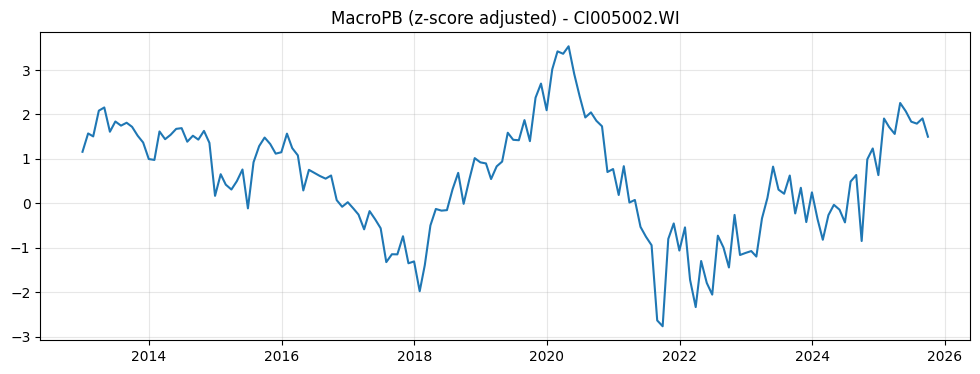

In [161]:
RAW_START = "20100101"
OUT_START = "20121231"
END_DT    = "20250930"

TARGET_IND  = "CI005002.WI"
WIN         = 36
MINP        = 12
ALPHA_TREND = 0.7

TARGET_TERM = 2.2
CURVE_CORP  = "中债企业债收益率曲线(AA-)"

def to_code_tuple_str(codes):
    return "(" + ",".join([f"'{x}'" for x in codes]) + ")"

def rolling_z(s, win=36, minp=12):
    m  = s.rolling(win, min_periods=minp).mean()
    sd = s.rolling(win, min_periods=minp).std()
    return (s - m) / sd

def month_last(df, date_col="TRADE_DT", key_col="S_INFO_WINDCODE", val_cols=()):
    df = df.sort_values([key_col, date_col]).copy()
    df[date_col] = pd.to_datetime(df[date_col])
    return (
        df.set_index(date_col)
          .groupby(key_col)[list(val_cols)]
          .resample("M").last()
          .reset_index()
    )


code_tuple_str = to_code_tuple_str(cics_level1)


sql_val = f"""
SELECT
    TRADE_DT,
    S_INFO_WINDCODE,
    PB_LF AS PB
FROM WIND.AINDEXVALUATION
WHERE S_INFO_WINDCODE IN {code_tuple_str}
  AND TRADE_DT >= '{RAW_START}'
  AND TRADE_DT <= '{END_DT}'
ORDER BY TRADE_DT, S_INFO_WINDCODE
"""
val = pd.read_sql(sql_val, con)
val["TRADE_DT"] = pd.to_datetime(val["TRADE_DT"])
val_m = month_last(val, val_cols=("PB",))


sql_px = f"""
SELECT
    TRADE_DT,
    S_INFO_WINDCODE,
    S_DQ_CLOSE
FROM WIND.AINDEXINDUSTRIESEODCITICS
WHERE S_INFO_WINDCODE IN {code_tuple_str}
  AND TRADE_DT >= '{RAW_START}'
  AND TRADE_DT <= '{END_DT}'
ORDER BY TRADE_DT, S_INFO_WINDCODE
"""
px = pd.read_sql(sql_px, con)
px["TRADE_DT"] = pd.to_datetime(px["TRADE_DT"])
px_m = (
    month_last(px, val_cols=("S_DQ_CLOSE",))
    .rename(columns={"S_DQ_CLOSE": "CLOSE"})
)

px_m = px_m.sort_values(["S_INFO_WINDCODE", "TRADE_DT"]).copy()
px_m["RET_1M"]   = px_m.groupby("S_INFO_WINDCODE")["CLOSE"].pct_change(1)
px_m["RET_12M"]  = px_m.groupby("S_INFO_WINDCODE")["CLOSE"].pct_change(12)
px_m["MOM_12_1"] = px_m["RET_12M"] - px_m["RET_1M"]


df = val_m.merge(
    px_m[["TRADE_DT", "S_INFO_WINDCODE", "MOM_12_1"]],
    on=["TRADE_DT", "S_INFO_WINDCODE"],
    how="inner"
)


macro_trend = (
    df.groupby("TRADE_DT")["MOM_12_1"]
      .mean()
      .rename("TREND_MKT")
      .to_frame()
      .reset_index()
)
macro_trend["TREND_MKT_Z"] = rolling_z(macro_trend["TREND_MKT"], WIN, MINP)

df = df.merge(macro_trend[["TRADE_DT", "TREND_MKT_Z"]], on="TRADE_DT", how="left")
df["PB_Z"] = df.groupby("S_INFO_WINDCODE")["PB"].transform(lambda s: rolling_z(s, WIN, MINP))
df["MACROPB_TREND"] = (-df["PB_Z"]) + ALPHA_TREND * df["TREND_MKT_Z"]


sql_money = f"""
SELECT
    TRADE_DT,
    B_INFO_RATE AS SHIBOR
FROM WIND.SHIBORPRICES
WHERE B_INFO_TERM = '1W'
  AND TRADE_DT >= '{RAW_START}'
  AND TRADE_DT <= '{END_DT}'
ORDER BY TRADE_DT
"""
money = pd.read_sql(sql_money, con)
money["TRADE_DT"] = pd.to_datetime(money["TRADE_DT"])

money_m = (
    money.sort_values("TRADE_DT")
         .set_index("TRADE_DT")[["SHIBOR"]]
         .resample("M").last()
         .reset_index()
)
money_m["MONEY_Z"] = rolling_z(money_m["SHIBOR"], WIN, MINP)

df = df.merge(money_m[["TRADE_DT", "MONEY_Z"]], on="TRADE_DT", how="left")
df["MACROPB_MONEY"] = (-df["PB_Z"]) - df["MONEY_Z"]


sql_credit = f"""
SELECT
    TRADE_DT,
    B_ANAL_YIELD
FROM WIND.CBONDCURVECNBD
WHERE B_ANAL_CURVENAME = '{CURVE_CORP}'
  AND B_ANAL_CURVETERM = {TARGET_TERM}
  AND TRADE_DT >= '{RAW_START}'
  AND TRADE_DT <= '{END_DT}'
ORDER BY TRADE_DT
"""
credit = pd.read_sql(sql_credit, con)
credit["TRADE_DT"] = pd.to_datetime(credit["TRADE_DT"], format="%Y%m%d")
credit = credit.rename(columns={"B_ANAL_YIELD": "AA_YIELD"}).dropna()

credit_m = (
    credit.set_index("TRADE_DT")[["AA_YIELD"]]
          .resample("M").last()
          .reset_index()
)
credit_m["CREDIT_Z"] = rolling_z(credit_m["AA_YIELD"], WIN, MINP)

df = df.merge(credit_m[["TRADE_DT", "CREDIT_Z"]], on="TRADE_DT", how="left")
df["MACROPB_CREDIT"] = (-df["PB_Z"]) - df["CREDIT_Z"]


df["MACROPB"] = (df["MACROPB_TREND"] + df["MACROPB_MONEY"] + df["MACROPB_CREDIT"]) / 3


df_out = df[df["TRADE_DT"] >= pd.to_datetime(OUT_START)].copy()

macro_panel = (
    df_out.pivot(index="TRADE_DT", columns="S_INFO_WINDCODE", values="MACROPB")
          .sort_index()
)

market_df_all = (
    macro_panel.reset_index()
               .rename(columns={"TRADE_DT": "dt"})
               .melt(id_vars="dt", var_name="INDEX_CODE", value_name="M_MACROPB")
)
market_df_all["TRADE_DT"] = market_df_all["dt"].dt.strftime("%Y%m%d").astype(int)
market_df_all = market_df_all[market_df_all["TRADE_DT"] >= int(OUT_START)]
market_df_all = market_df_all[["INDEX_CODE", "TRADE_DT", "M_MACROPB"]].sort_values(["INDEX_CODE", "TRADE_DT"]).reset_index(drop=True)


plt.figure(figsize=(12, 4))
plt.plot(macro_panel.index, macro_panel[TARGET_IND])
plt.title(f"MacroPB (z-score adjusted) - {TARGET_IND}")
plt.grid(True, alpha=0.3)
plt.show()


## 合并因子

In [174]:
START_DT = 20121231
END_DT   = 20250930

def _to_trade_dt_int(s: pd.Series) -> pd.Series:
    if pd.api.types.is_datetime64_any_dtype(s):
        return s.dt.strftime("%Y%m%d").astype("Int64")
    x = s.astype(str).str.strip()
    x = x.replace({"None": np.nan, "nan": np.nan, "NaT": np.nan, "": np.nan})
    m = x.str.fullmatch(r"\d{8}")
    out = pd.Series(pd.array([pd.NA]*len(x), dtype="Int64"), index=x.index)
    out[m] = x[m].astype("Int64")
    miss = (~m) & x.notna()
    if miss.any():
        dt = pd.to_datetime(x[miss], errors="coerce")
        out.loc[miss] = dt.dt.strftime("%Y%m%d").astype("Int64")
    return out

def ensure_trade_dt(df: pd.DataFrame, dt_col="TRADE_DT") -> pd.DataFrame:
    x = df.copy()
    x[dt_col] = _to_trade_dt_int(x[dt_col])
    x = x.dropna(subset=[dt_col])
    x[dt_col] = x[dt_col].astype(int)
    return x

trade_days = ensure_trade_dt(crowd_df_use[["TRADE_DT"]])["TRADE_DT"].drop_duplicates().sort_values()
trade_days = trade_days[(trade_days >= START_DT) & (trade_days <= END_DT)].to_numpy()

code_tuple_str = "(" + ",".join([f"'{x}'" for x in cics_level1]) + ")"

sql = f"""
SELECT
    TRADE_DT,
    S_INFO_WINDCODE AS INDEX_CODE,
    S_DQ_CLOSE
FROM WIND.AINDEXINDUSTRIESEODCITICS
WHERE S_INFO_WINDCODE IN {code_tuple_str}
  AND TRADE_DT >= '{START_DT}'
  AND TRADE_DT <= '{END_DT}'
ORDER BY S_INFO_WINDCODE, TRADE_DT
"""

ret_raw = pd.read_sql(sql, con)
ret_raw = ensure_trade_dt(ret_raw, dt_col="TRADE_DT")
ret_raw["INDEX_CODE"] = ret_raw["INDEX_CODE"].astype(str)
ret_raw["S_DQ_CLOSE"] = pd.to_numeric(ret_raw["S_DQ_CLOSE"], errors="coerce")
ret_raw = ret_raw.sort_values(["INDEX_CODE","TRADE_DT"]).drop_duplicates(["INDEX_CODE","TRADE_DT"], keep="last")

def to_daily_ret_from_close(df_close, dt_days, index_col="INDEX_CODE", dt_col="TRADE_DT", close_col="S_DQ_CLOSE"):
    x = df_close[(df_close[dt_col] >= START_DT) & (df_close[dt_col] <= END_DT)].copy()
    codes = x[index_col].unique()
    idx = pd.MultiIndex.from_product([dt_days, codes], names=[dt_col, index_col])

    x = x.set_index([dt_col, index_col]).sort_index().reindex(idx)
    x[close_col] = x.groupby(level=index_col)[close_col].ffill()

    x = x.reset_index()
    x["RET"] = x.groupby(index_col)[close_col].pct_change()
    return x[[dt_col, index_col, "RET"]]

ret_panel = to_daily_ret_from_close(ret_raw, trade_days)

DROP_CODES = {"CI005029.WI", "CI005030.WI"}
ret_panel = ret_panel.loc[~ret_panel["INDEX_CODE"].isin(DROP_CODES)].reset_index(drop=True)

ret_panel.to_csv("canslim_ret.csv", index=False, encoding="utf-8-sig")


In [175]:
from functools import reduce

def to_daily(df, value_cols, keep="last", index_col="INDEX_CODE", dt_col="TRADE_DT"):
    x = ensure_trade_dt(df, dt_col=dt_col)
    x = x[(x[dt_col] >= START_DT) & (x[dt_col] <= END_DT)]
    if x.empty:
        return pd.DataFrame(columns=[dt_col, index_col] + list(value_cols))

    x[index_col] = x[index_col].astype(str)
    for c in value_cols:
        x[c] = pd.to_numeric(x[c], errors="coerce") if c in x.columns else np.nan

    x = x.sort_values([index_col, dt_col]).drop_duplicates([index_col, dt_col], keep=keep)

    codes = x[index_col].unique()
    idx = pd.MultiIndex.from_product([trade_days, codes], names=[dt_col, index_col])

    x = x.set_index([dt_col, index_col]).sort_index().reindex(idx)
    x[list(value_cols)] = x.groupby(level=index_col)[list(value_cols)].ffill()

    return x.reset_index()

dfs = []

dfs.append(to_daily(crowd_df_use[["INDEX_CODE","TRADE_DT","CROWD"]], ["CROWD"]))
dfs.append(to_daily(analyst_df[["INDEX_CODE","TRADE_DT","ANALYST_REC","ANALYST_UP3M"]], ["ANALYST_REC","ANALYST_UP3M"]))
dfs.append(to_daily(df_np[["INDEX_CODE","TRADE_DT","NP_SUE","NP_DELTA_ROEQ","NP_PROFIT_YOY"]], ["NP_SUE","NP_DELTA_ROEQ","NP_PROFIT_YOY"]))
dfs.append(to_daily(smart_df[["INDEX_CODE","TRADE_DT","SMART"]], ["SMART"]))
dfs.append(to_daily(leader_all[["INDEX_CODE","TRADE_DT","PM","VA"]], ["PM","VA"]))

inst_cols = [c for c in ["I_SELLSIDE","I_SELLSIDE_CHG","I_UNDER_W"] if c in inst_df_all.columns]
dfs.append(to_daily(inst_df_all[["INDEX_CODE","TRADE_DT"] + inst_cols], inst_cols))

dfs.append(to_daily(market_df_all[["INDEX_CODE","TRADE_DT","M_MACROPB"]], ["M_MACROPB"]))

factor_panel = reduce(lambda l, r: l.merge(r, on=["INDEX_CODE","TRADE_DT"], how="outer"), dfs)
factor_panel = factor_panel.sort_values(["INDEX_CODE","TRADE_DT"]).reset_index(drop=True)

factor_panel = (
    factor_panel
    .assign(_rn=factor_panel.groupby("INDEX_CODE").cumcount())
    .loc[lambda x: x["_rn"] > 0]
    .drop(columns="_rn")
    .reset_index(drop=True)
)

DROP_CODES = {"CI005029.WI", "CI005030.WI"}
factor_panel = factor_panel.loc[~factor_panel["INDEX_CODE"].isin(DROP_CODES)].reset_index(drop=True)

factor_panel.to_csv("canslim_factors.csv", index=False, encoding="utf-8-sig")